['positions_timestep_days_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_10.txt', 'readable.py', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
['McKenzie_orbit_timestep_seconds_scale_1000.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000.txt']
['Folkner_orbit_timestep_seconds_scale_10.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1.txt', 'Folkner_orbit_timestep_seconds_scale_1.txt', 'NGO_1M_10deg_synthlisa_timestep_days_scale_1000.txt']
Dir_extr:new_1_synthlisa_armcalc
Dir_extr:new_1_synthlisa_armcalc
Dir_extr:new_1_synthlisa_armcalc
Dir_extr:new_1_synthlisa_armcalc
Dir_extr:new_1_synthlisa_armcalc
Dir_extr:new_1_synthlisa_armcalc
Getting scale by filename:
1000.0

Getting timestep by filename:
days


Importing Orbit
400 datapoints
Done in 0.420467

Obtaining proper LISA object
Done in 0.000278
Offset: 3
Data /home/ester/git/synthlisa/examples/manual-examples/output_files/20181031-new_1_synthlisa_armca

Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-PAA.png saved in:
/home/ester/git/synthlisa/examples/manual-examples/figures/20181031-new_1_synthlisa_armcalc/
Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-diffPAA.png saved in:
/home/ester/git/synthlisa/examples/manual-examples/figures/20181031-new_1_synthlisa_armcalc/
Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-PAA_all.png saved in:
/home/ester/git/synthlisa/examples/manual-examples/figures/20181031-new_1_synthlisa_armcalc/
Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-Breathing_angles.png saved in:
/home/ester/git/synthlisa/examples/manual-examples/figures/20181031-new_1_synthlisa_armcalc/
Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-send_receive_angle.png saved in:
/home/ester/git/synthlisa/examples/manual-examples/figures/20181031-new_1_synthlisa_armcalc/
Figure Hallion_2pt5G_orbits_pos_uniquedays_timestep_days_scale_1000-W

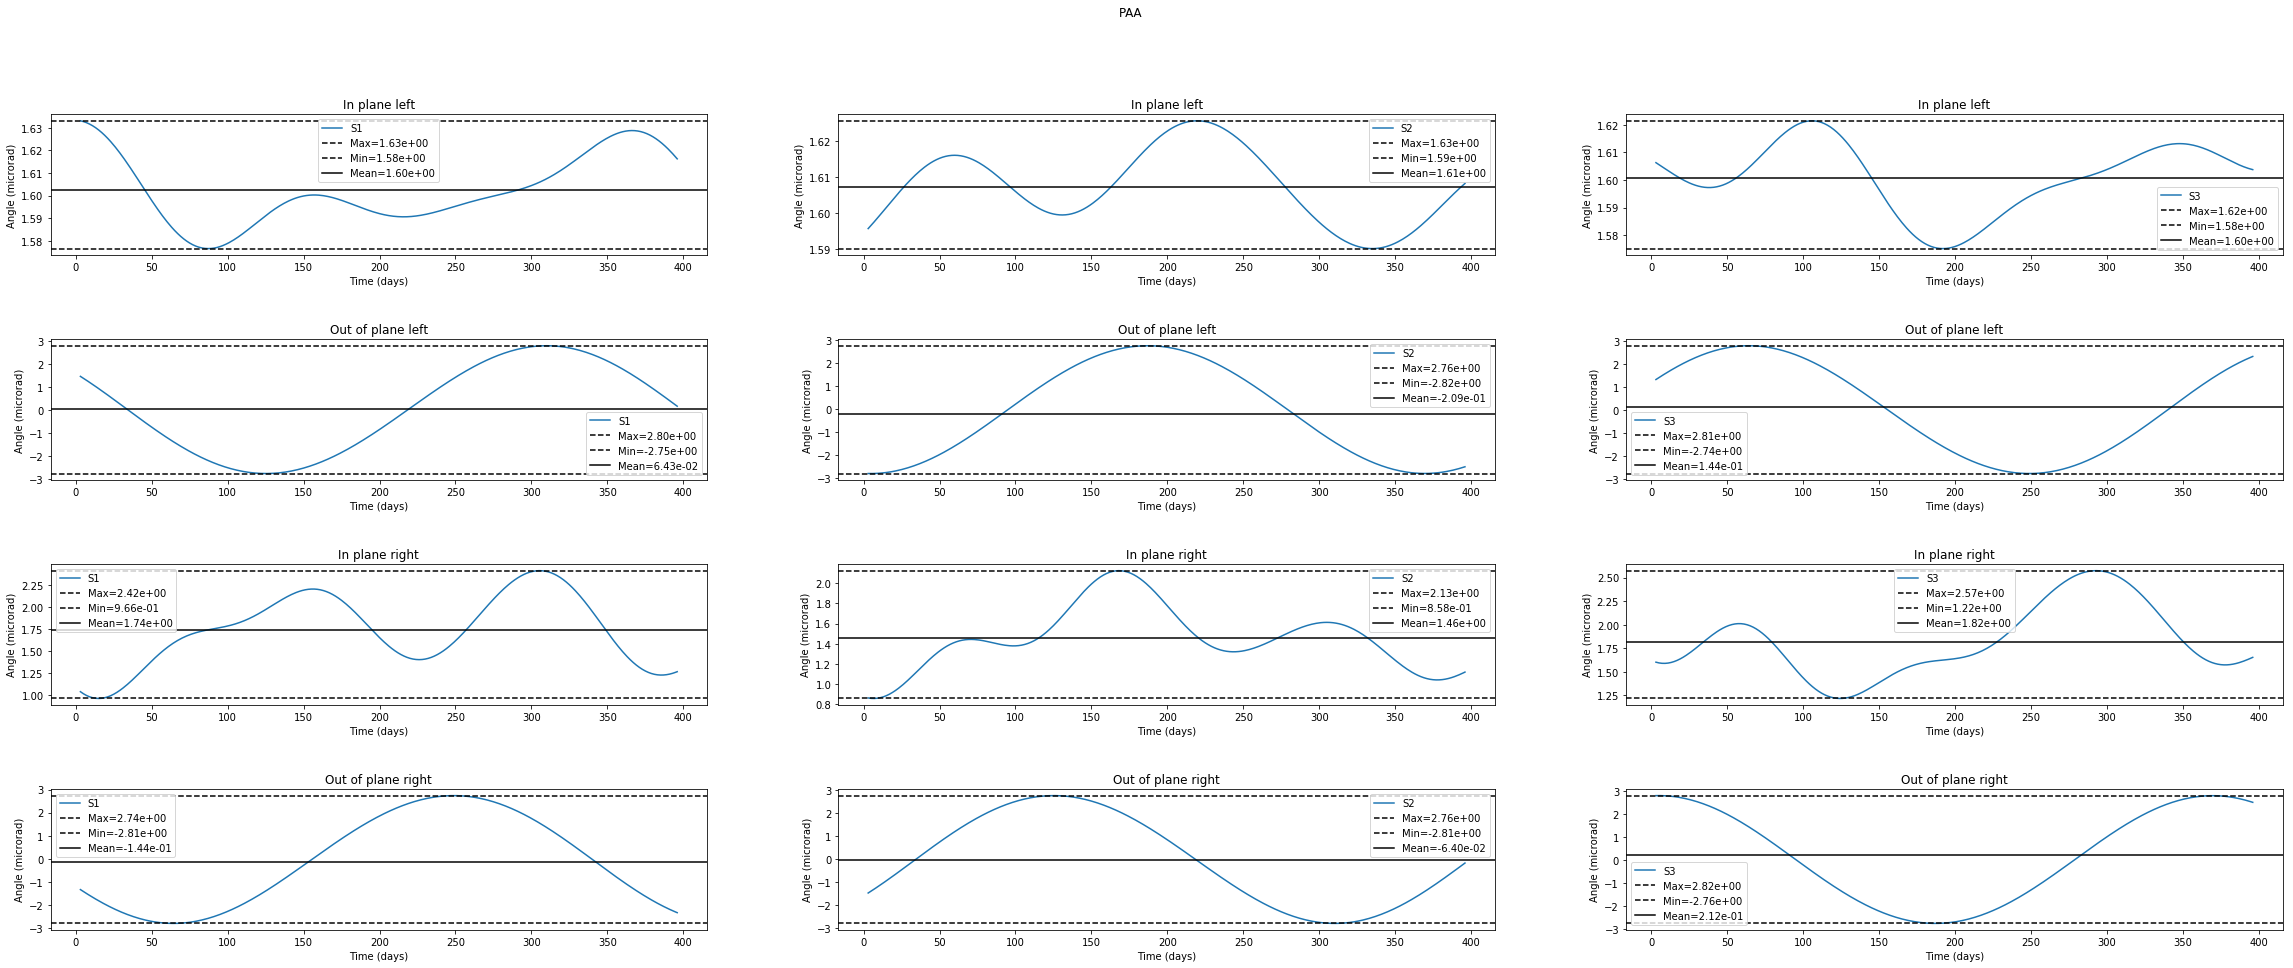

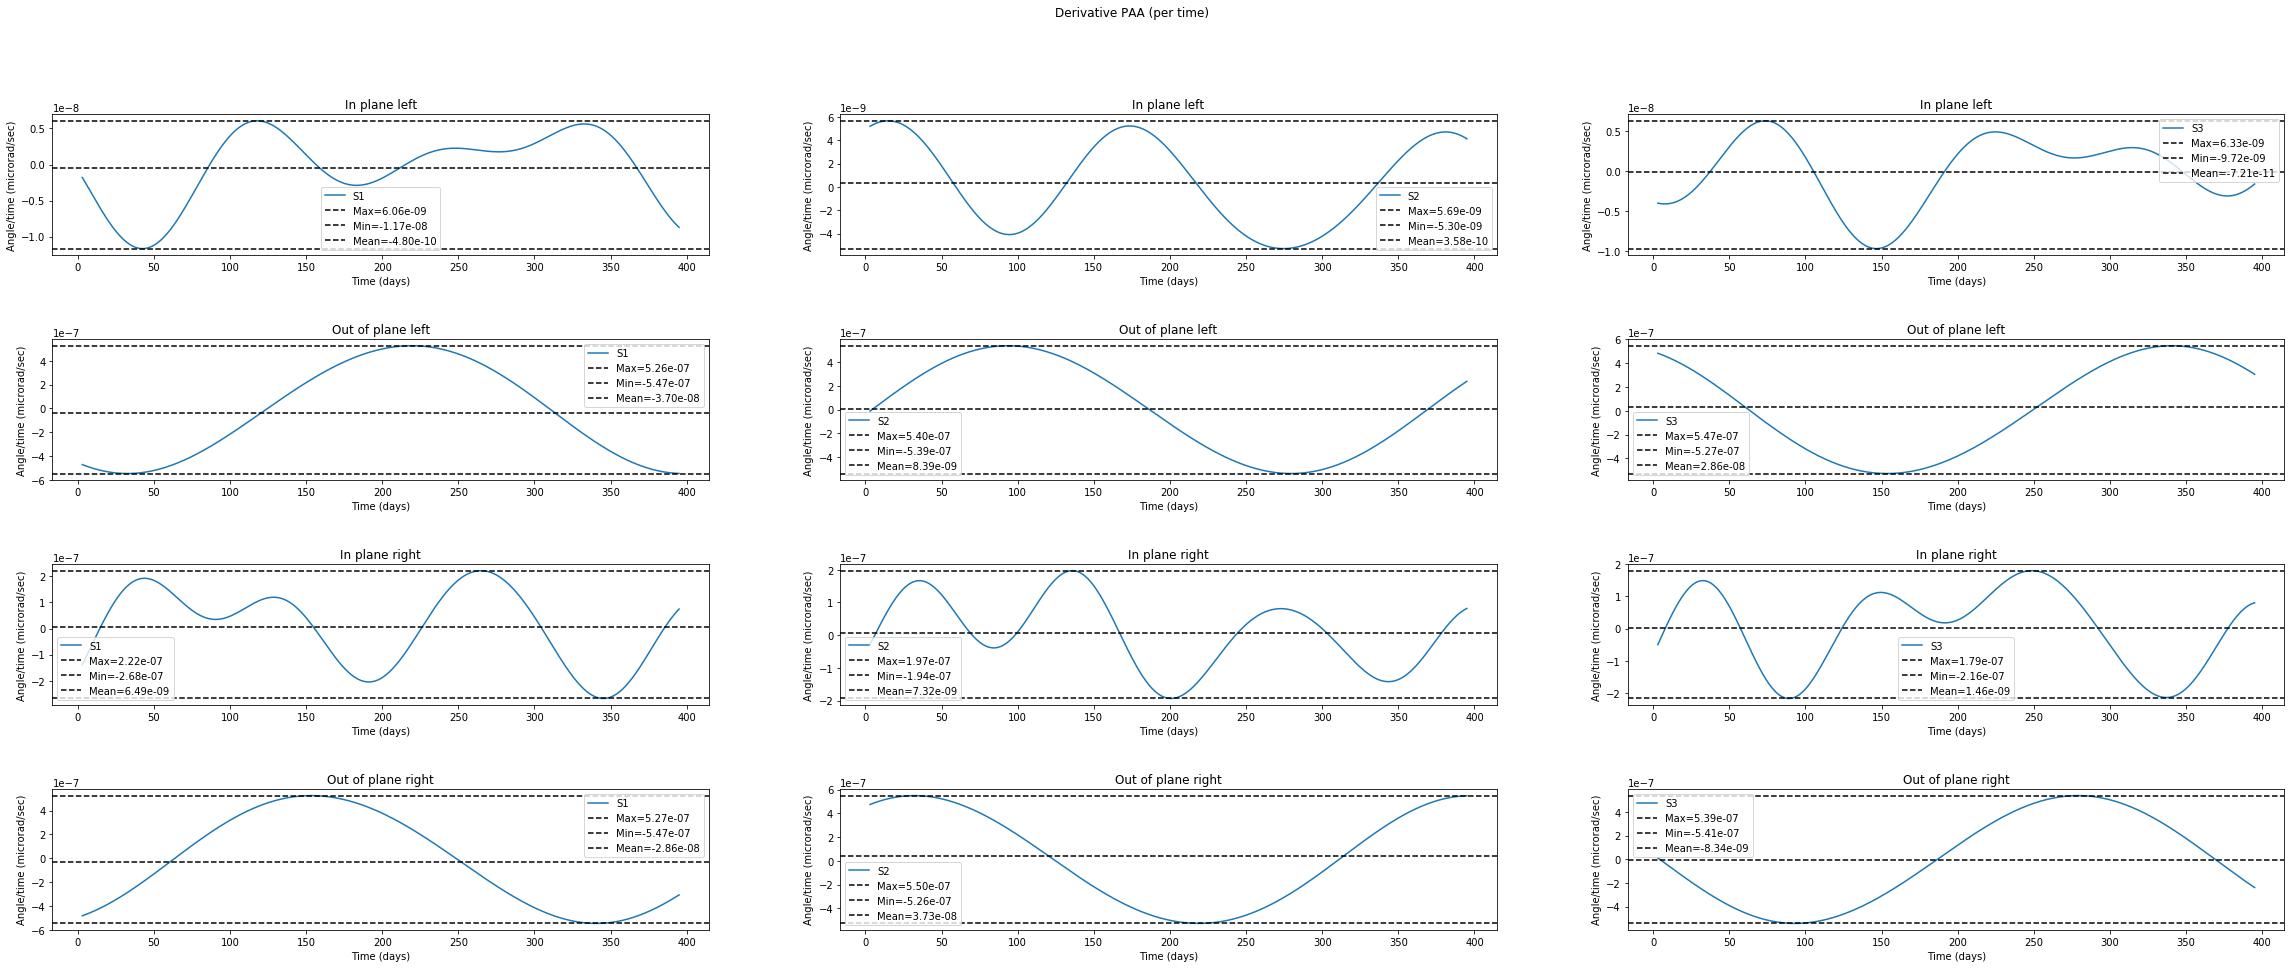

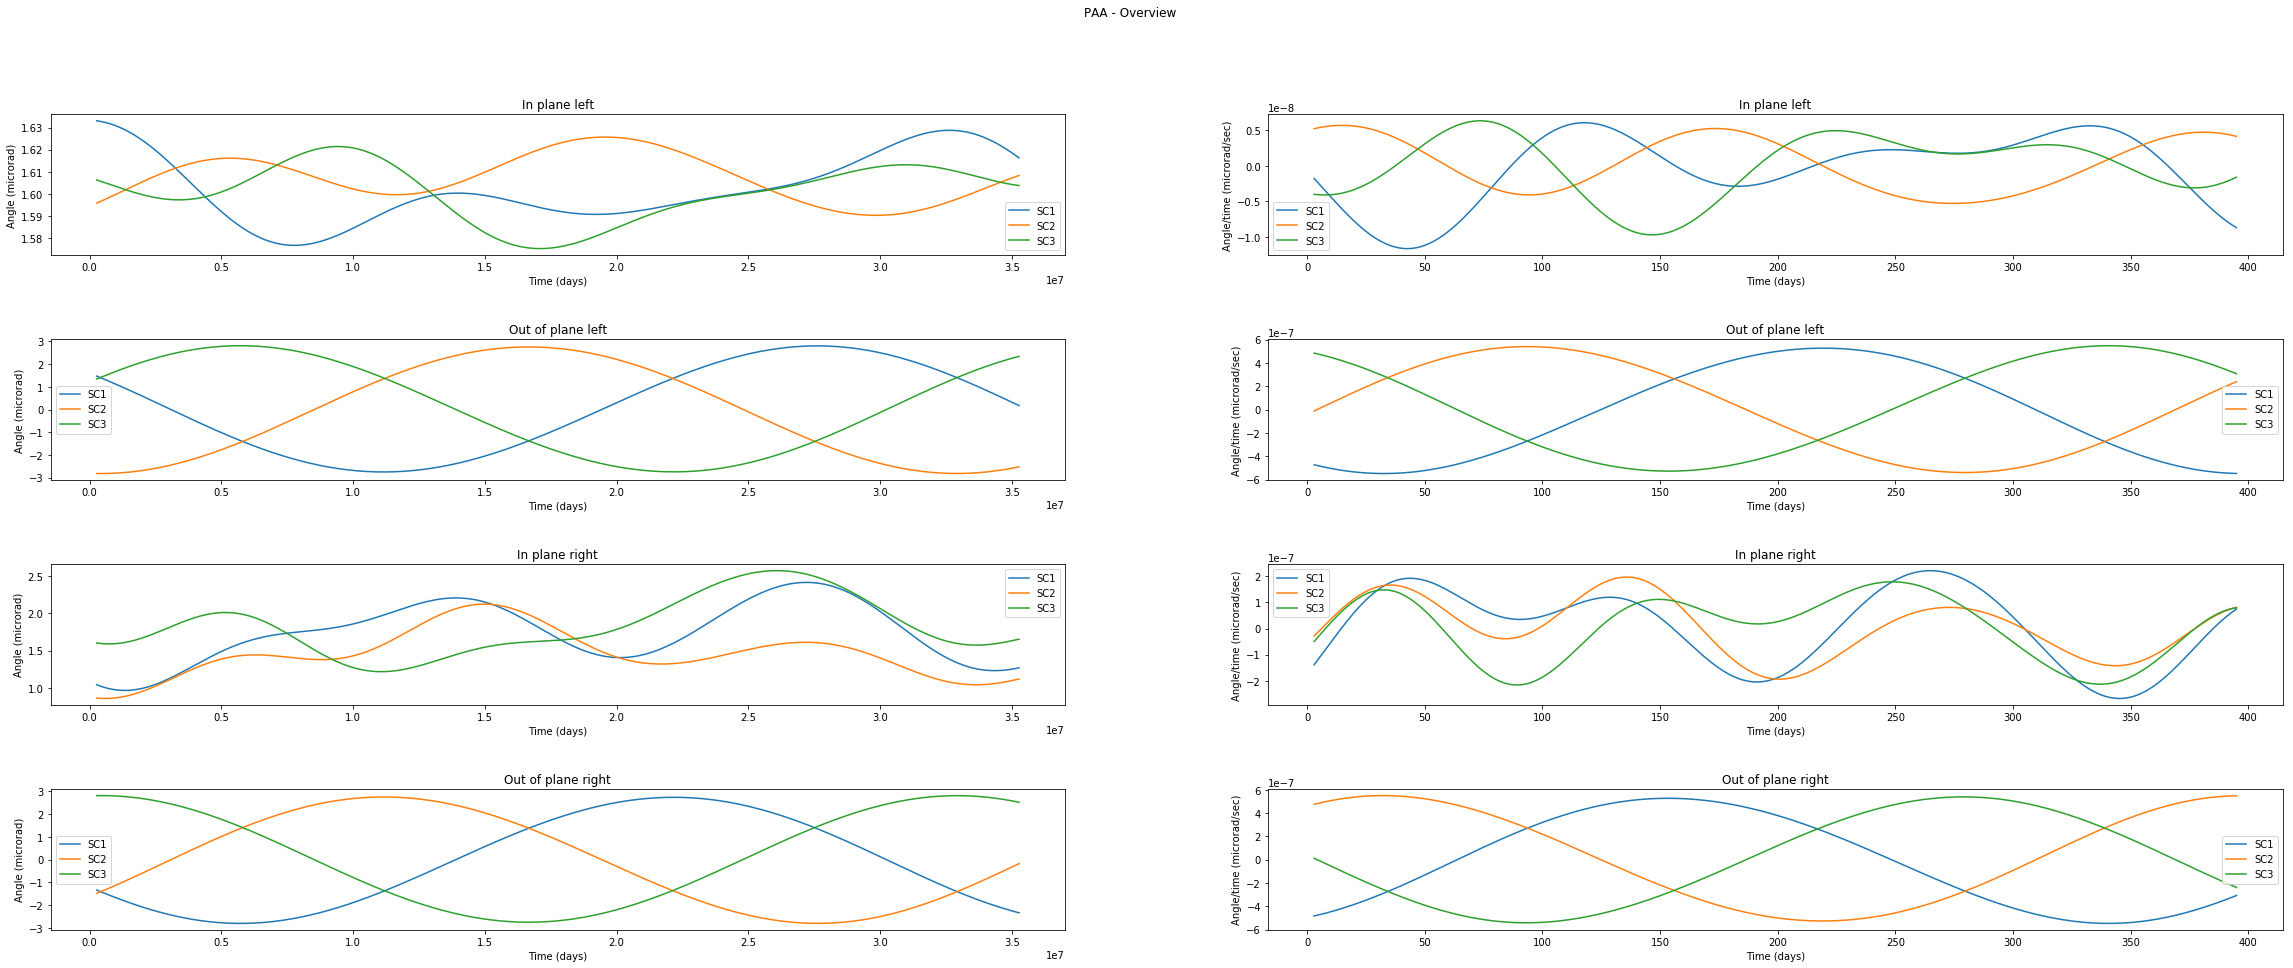

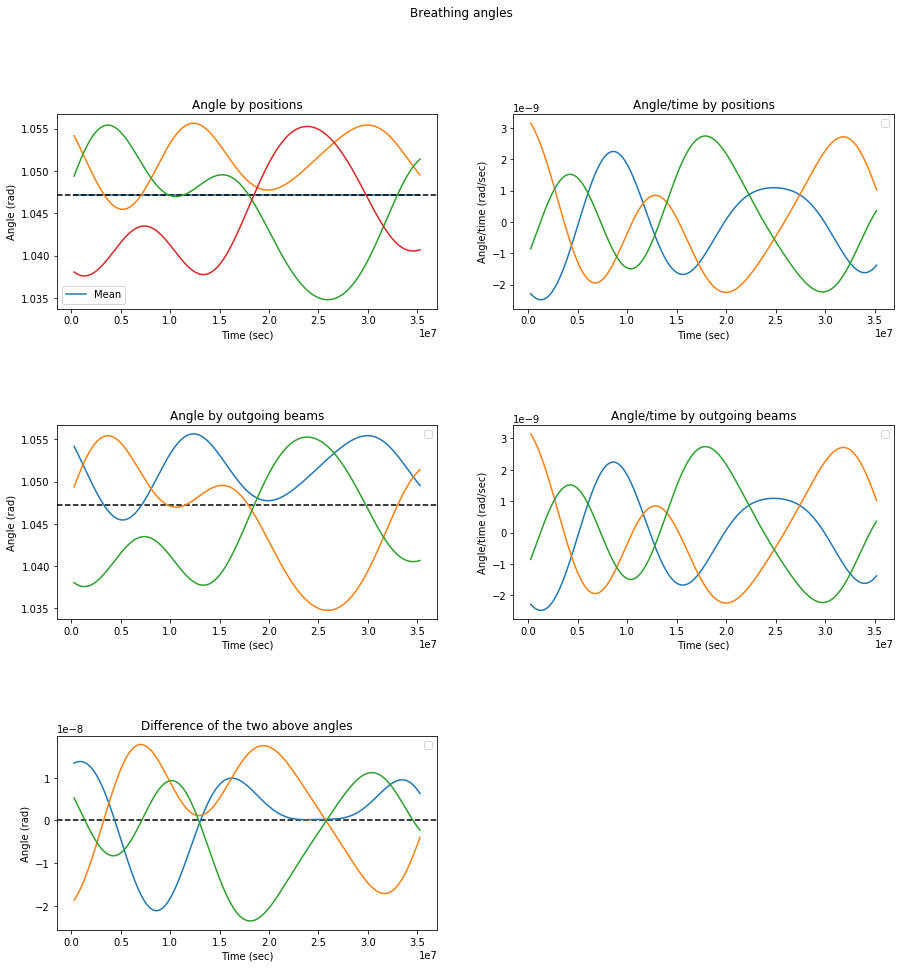

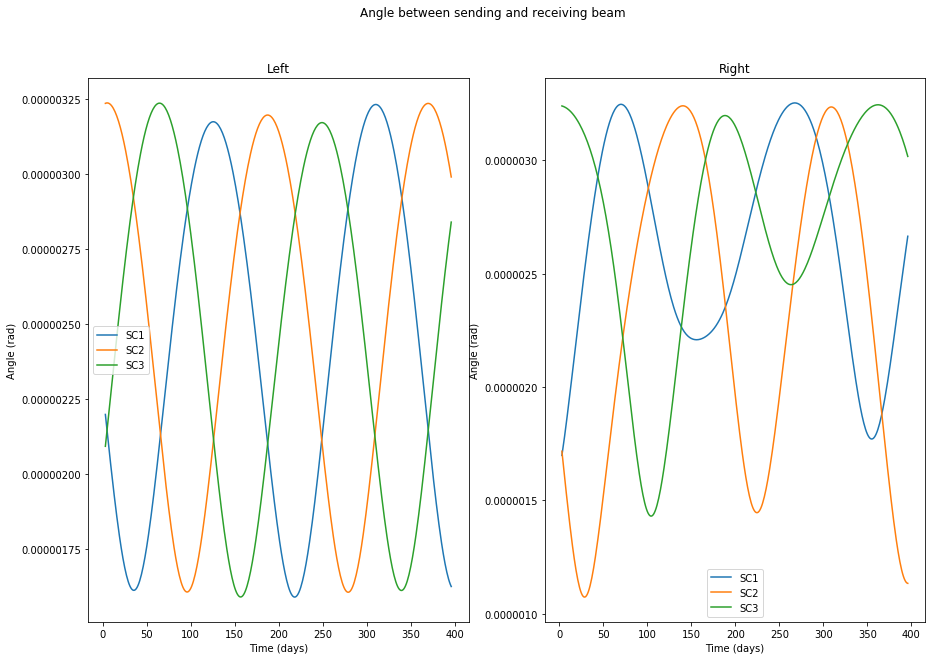

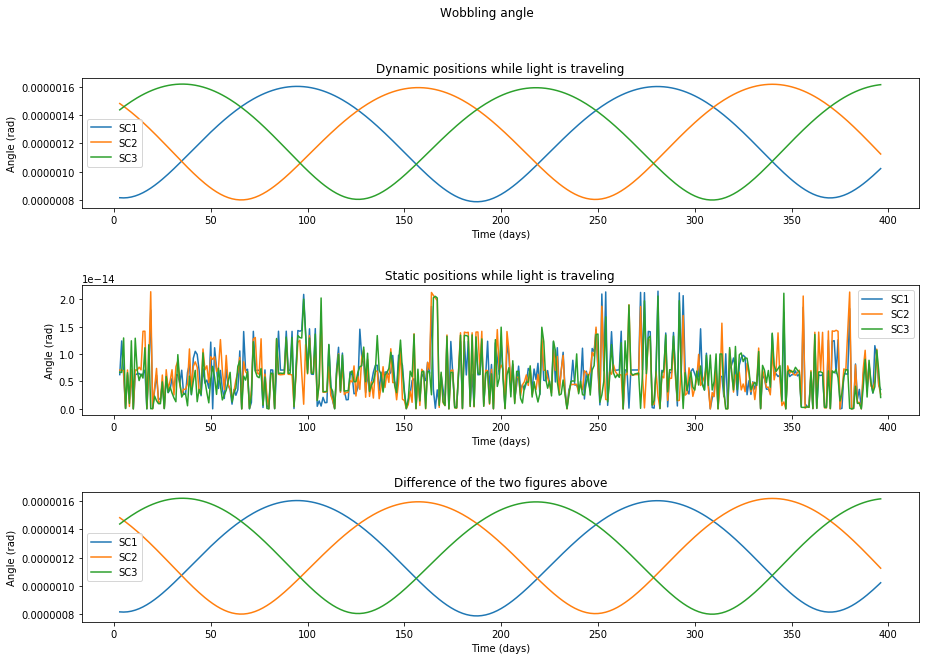

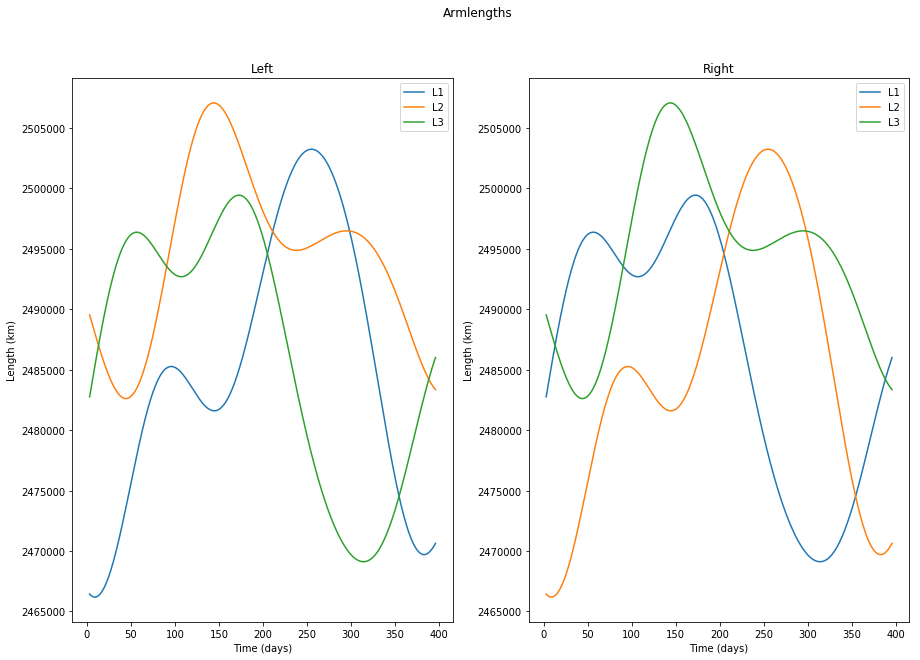

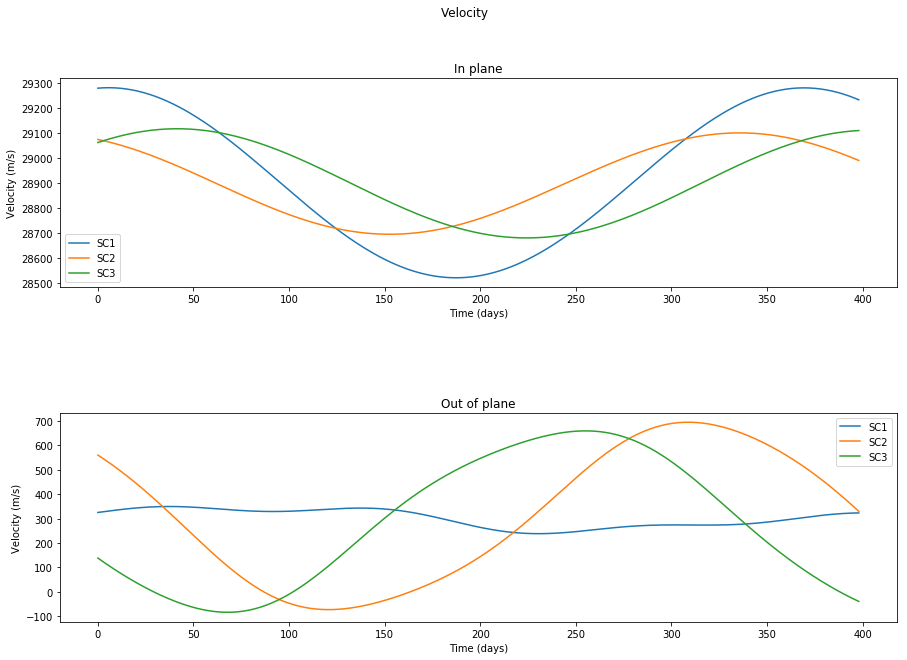

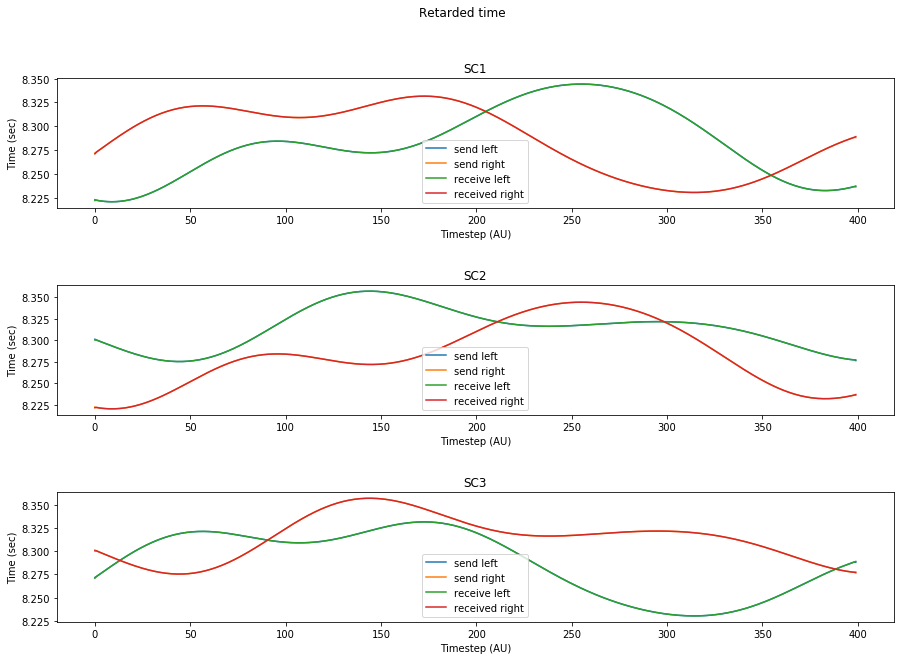

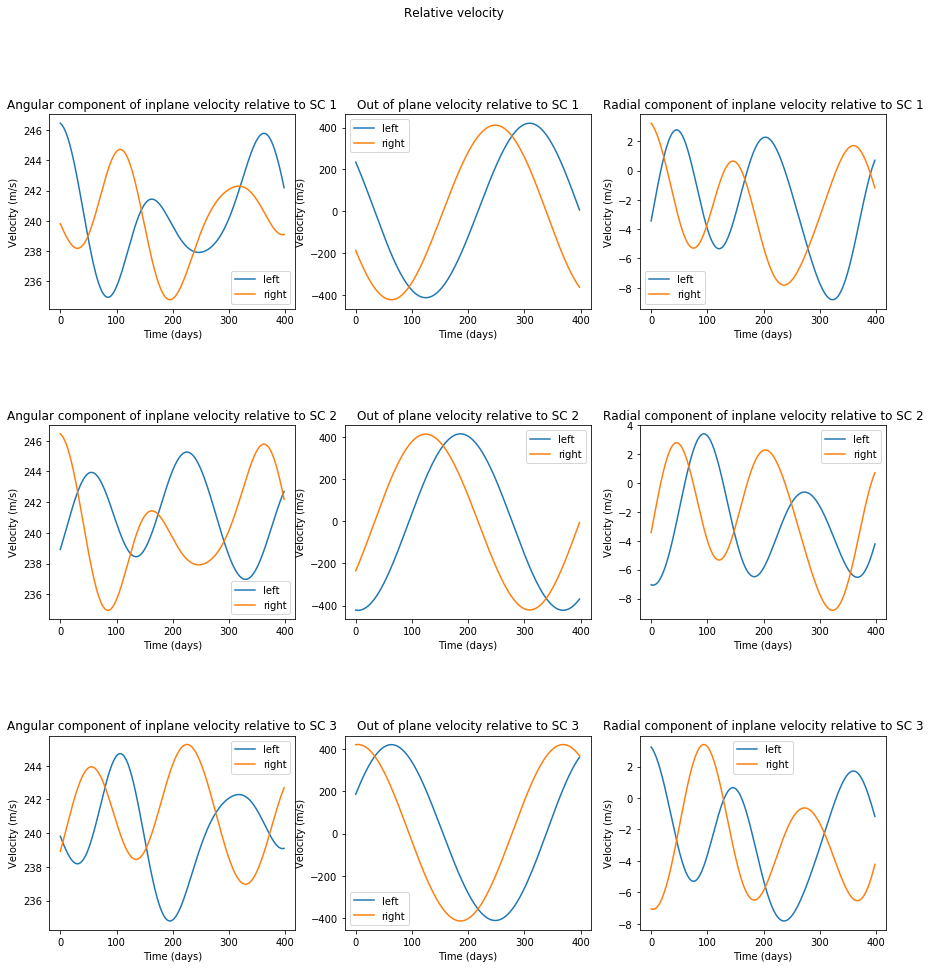

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from synthlisa import *
import numpy as np
import matplotlib.pyplot as plt
import os
from fractions import Fraction
import math
import datetime
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from class_orbit import orbit
from PAA import PAA
from PAA import la
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')
#warnings.filterwarnings("error")
import scipy.optimize


plot_on=True
year2sec=32536000
day2sec=year2sec/365.25
c=300000000
noise_check=False
home='/home/ester/git/synthlisa/'
directory_imp='lisasim/data/'




#--------
dir_orbits='/home/ester/git/synthlisa/orbits/'
LISA_opt = True
delay=True#e'Not ahead'#False

filename_list=[]

for (dirpath, dirnames, filenames) in os.walk(dir_orbits):
    print(filenames)
    for i in filenames:
        if i.split('.')[-1]=='txt':
            a = dirpath+'/'+i
            a = a.replace('//','/')
            filename_list.append(a)

#filename_list=[filename_list[0]]
#timeunit=['days']
#dir_extr='new_1_test'
dir_extr='new_1_synthlisa_armcalc'
#dir_extr='new_4_interp_arminterp'
#timeunit=['seconds','days','days']
timeunit='Default'#['days']
arm_influence=True
length_calc=400#'all'
#tstep=3600
tstep=False
count=0
method = 'fsolve'
select='Hallion'#'Folkner_orbit_timestep_seconds_scale_10'
PAA_res={}
filename_done=[]
for i in filename_list:
    filename_name = i.split('/')[-1]
    if i == filename_list[0]:
        new_folder=False # Adjust if you (don't) want to override
    else:
        new_folder=False
    print('Dir_extr:'+dir_extr)
    if select == 'all':
        if '/try/' in i:
            execute = False
        else:
            execute = True
    else:
        if select in i:
            execute = True
        else:
            execute = False

    if filename_name in filename_done:
        execute = False

    if execute == True:
        filename_save = i.split('/')[-1].split('_')[0]
        PAA_res[filename_save]=PAA(home = home,filename = i,directory_imp=False,read_max = length_calc,plot_on=True,dir_extr=dir_extr,new_folder=new_folder,timeunit=timeunit,LISA=LISA_opt,arm_influence=arm_influence,tstep=tstep,delay=delay,method=method)
        PAA_res[str(count+1)] = PAA_res[filename_save]
        filename_done.append(filename_name)
        count=count+1




for k in range(0,len(PAA_res.keys())/2):
    data = PAA_res[str(k+1)]


In [2]:
# Parameters for point PAAM
PAA_out_lim = 0.5*0.000001
PAA_out_marge = 0.1*0.000001


In [3]:
for k in range(0,len(PAA_res.keys())/2):
    data = PAA_res[str(k+1)]

In [4]:
[PAA_in_l,PAA_out_l,PAA_in_r,PAA_out_r] = data.PAA_ret
[v_l,v_r,u_l,u_r] = data.beam

In [5]:
def aim(values,lim,step,offset=0):
    PAA_set_list=[]
    PAA_control_list=[]
    PAA_step_list=[]
    values_original=[]
    for i in range(0,len(values)):
        PAA_set_vec=[]
        PAA_control_vec=[]

        PAA_set = 0
        values_calc = values[i][offset:-data.offset]
        for j in range(0,len(values_calc)):
            PAA_val = values_calc[j]+PAA_set

            while PAA_val>lim:
                PAA_set = PAA_set - step
                PAA_val = PAA_val - step

            while PAA_val<-lim:
                PAA_set = PAA_set + step
                PAA_val = PAA_val + step
            PAA_set_vec.append(PAA_set)
            PAA_control_vec.append(PAA_val)
        PAA_set_list.append(np.array(PAA_set_vec))
        PAA_control_list.append(np.array(PAA_control_vec))
        values_original.append(values_calc)
        
    return [[values_original,PAA_control_list,PAA_set_list],[lim,step,offset]]

titles=['l_in','l_out','r_in','r_out']
PAA_all={}
for k in range(0,len(data.PAA_ret)):
    title = titles[k]
    [[PAA_part_original,PAA_part_control,PAA_part_set],[lim,step,offset]] = aim(data.PAA_ret[k],0.5*0.000001,0.1*0.000001,data.offset)
    
    PAA_all[title]=PAA_part_original
    
    
    

In [65]:
len(PAA_part_set)

3

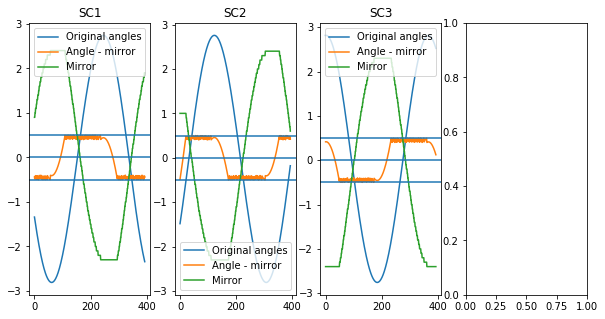

In [64]:
f,ax = plt.subplots(1,4,figsize=(10,5))
for i in range(0,len(PAA_part_set)):
    ax[i].plot(PAA_part_original[i]*1000000,label='Original angles')
    ax[i].plot(PAA_part_control[i]*1000000,label='Angle - mirror')
    ax[i].plot(PAA_part_set[i]*1000000,label='Mirror')
    ax[i].axhline(lim*1000000)
    ax[i].axhline(-lim*1000000)
    ax[i].axhline(0)
    ax[i].set_title('SC'+str(i+1))
    ax[i].legend(loc='best')
    
    #ax[i].plot((PAA_out_l[i][data.offset:-data.offset]+PAA_set_list[i])*1000000)
    

plt.show()

In [7]:
Kp=0.99
Kd=10
Ki=0

t=data.t_plot[0][offset:-offset]
r_t = PAA_part_original[0]
y_t = [r_t[0],r_t[1]]
e_t = [r_t[0] - y_t[0],r_t[1]-y_t[1]]
for i in range(2,len(r_t)):
    P = Kp*e_t[i-1]
    I = Ki*sum(e_t[0:i])*(t[i]-t[i-1])
    D = Kd*((e_t[i-1] - e_t[i-2])/(t[i-1]-t[i-2]))
    
    y_t.append(P+I+D)
    e_t.append(r_t[i]-y_t[i])


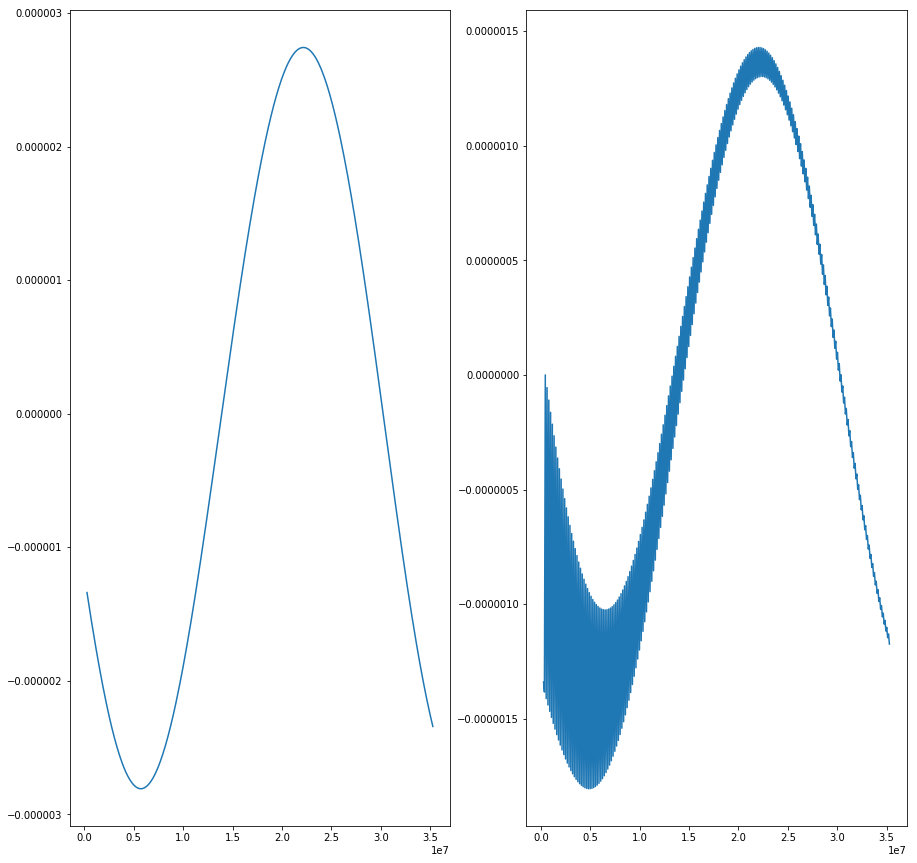

In [8]:
f,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].plot(t,r_t)
ax[1].plot(t,y_t)

In [9]:
def i_slr(i):
    i_self = i
    i_left = (i+1)%3
    i_right = (i+2)%3

    i_ret = [i_self,i_left,i_right]
    for j in range(0,len(i_ret)):
        if i_ret[j]==0:
            i_ret[j]=3

    return i_ret


In [10]:
# Parameters:
labda =1064*(10**-9) # m
eta_opt = 0.23 # ...look up
eta_pd = 0.68 # A/W
P_L = 1 # W ...verufy with new LISA technical speifications
D = 0.40 # Diameter [m]
h = 6.62607004*(10**-34) # Js
#c=300000000
#h = 1.98644568*(10**-25) # J/m
#c = 1
h = 1.0/(6.241506*(10**18))

In [11]:
P_v_l=[]
P_v_l0=[]
P_v_r=[]
P_v_r0=[]
phi_l_sn_q = []
phi_r_sn_q = []

for i in range(0,len(data.t_plot)):
    i_self = i+1
    t = data.t_plot[i]
    v_l_func = data.v_l_func_tot[i]
    v_r_func = data.v_r_func_tot[i]
    u_l_func = data.u_l_func_tot[i]
    u_r_func = data.u_r_func_tot[i]
    P_v_l_vec=[]
    P_v_l0_vec=[]
    P_v_r_vec=[]
    P_v_r0_vec=[]
    phi_l_sn_q_vec = []
    phi_r_sn_q_vec = []
    
    for j in range(0,len(t)):
        v_l = v_l_func(t[i])
        L = np.linalg.norm(v_l)
        ang_v_l_in = data.PAA_beam_next_sc[0][i][j] - np.radians(30)
        ang_v_l_out = data.PAA_beam_next_sc[1][i][j] - np.radians(30)
        P_rec0 = ((np.pi**2)*(D**4)*(eta_opt*P_L))/(16*(labda**2)*(L**2))
        P_rec = P_rec0*np.cos(ang_v_l_in)*np.cos(ang_v_l_out)
        P_v_l_vec.append(P_rec)
        P_v_l0_vec.append(P_rec0)

        phi_l_sn_q_vec.append((h/(eta_pd*(P_rec/4.0)))**0.5) # Shot noise per quadrant (upper limit)
            
        v_r = v_r_func(t[i])
        L = np.linalg.norm(v_r)
        ang_v_r_in = data.PAA_beam_next_sc[2][i][j] - np.radians(30)
        ang_v_r_out = data.PAA_beam_next_sc[3][i][j] - np.radians(30)
        P_rec0 = ((np.pi**2)*(D**4)*(eta_opt*P_L))/(16*(labda**2)*(L**2))
        P_rec = P_rec0*np.cos(ang_v_r_in)*np.cos(ang_v_r_out)
        P_v_r_vec.append(P_rec)
        P_v_r0_vec.append(P_rec0)

        phi_r_sn_q_vec.append((h/(eta_pd*(P_rec/4.0)))**0.5) # Shot noise per quadrant (upper limit)
    
    P_v_l.append(np.array(P_v_l_vec))
    P_v_l0.append(np.array(P_v_l0_vec))
    P_v_r.append(np.array(P_v_r_vec))
    P_v_r0.append(np.array(P_v_r0_vec))
    phi_l_sn_q.append(np.array(phi_l_sn_q_vec))
    phi_r_sn_q.append(np.array(phi_r_sn_q_vec))
    
    

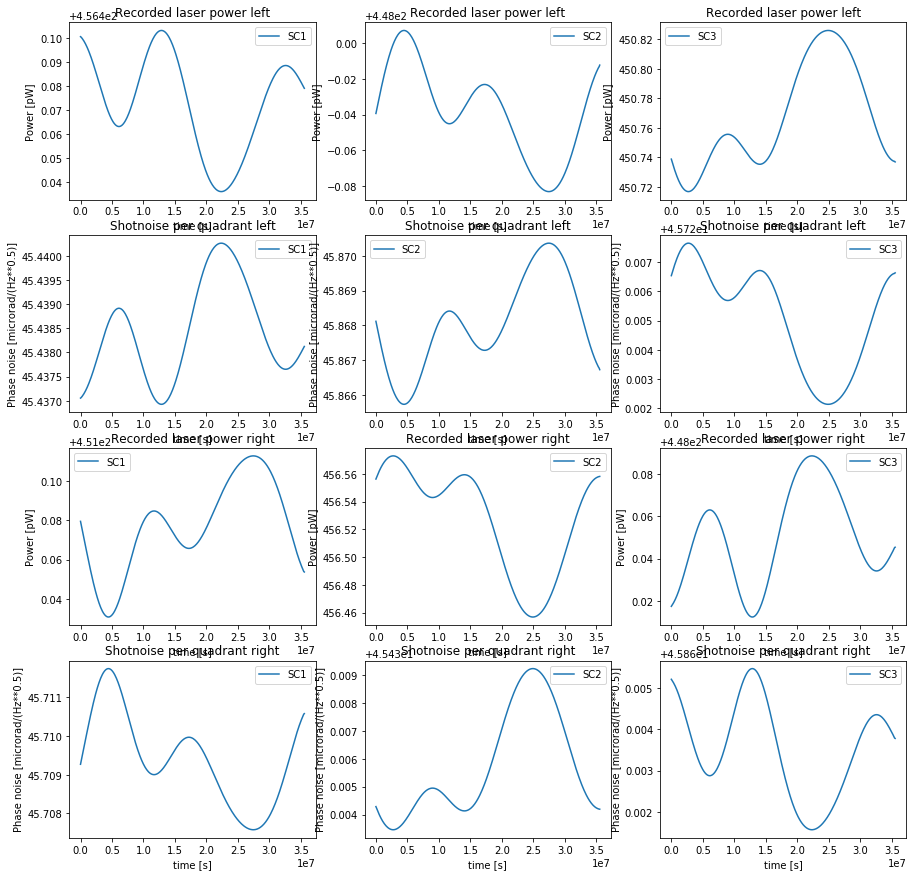

In [12]:
f,ax = plt.subplots(4,3,figsize=(15,15))
t_plot = data.t_plot
for i in range(0,len(ax[0])):
    ax[0,i].plot(t_plot[i],P_v_l[i]*(10**12),label='SC'+str(i+1))
    #ax[0,i].plot(t_plot[i],P_v_l0[i],label='SC'+str(i+1))
    
    ax[1,i].plot(t_plot[i],phi_l_sn_q[i]*1000000,label='SC'+str(i+1))
    
    ax[2,i].plot(t_plot[i],P_v_r[i]*(10**12),label='SC'+str(i+1))
    #ax[0,i].plot(t_plot[i],P_v_l0[i],label='SC'+str(i+1))
    
    ax[3,i].plot(t_plot[i],phi_r_sn_q[i]*1000000,label='SC'+str(i+1))

    for j in range(0,len(ax)):
        ax[j,i].legend(loc='best')
        ax[j,i].set_xlabel('time [s]')
        if j == 0 or j==2:
            ax[j,i].set_ylabel('Power [pW]')
            if j ==0:
                ax[j,i].set_title('Recorded laser power left')
            else:
                ax[j,i].set_title('Recorded laser power right')
        if j == 1 or j == 3:
            ax[j,i].set_ylabel('Phase noise [microrad/(Hz**0.5)]')
            if j==1:
                ax[j,i].set_title('Shotnoise per quadrant left')
            else:
                ax[j,i].set_title('Shotnoise per quadrant right')
            


        
    
    
    
        

In [13]:
from scipy import signal
#import matplotlib.pyplot as plt

In [14]:
f,Pxx_den = signal.periodogram(y_t,t[1]-t[0])

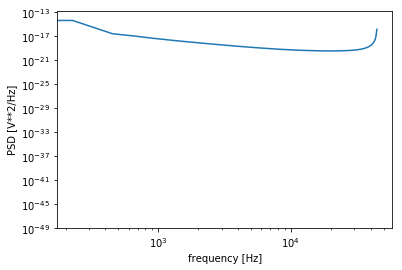

In [15]:
plt.loglog(f, Pxx_den)
#plt.ylim([1e-20, 10*max(Pxx_den)])

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


In [16]:
SD_PAAM = max(Pxx_den)

In [17]:
originallisa = OriginalLISA()
dt_opt = 1

In [18]:
a = stdopticalnoise(originallisa,dt_opt,SD_PAAM)

In [19]:
a

<synthlisa.lisaswig.InterpolatedSignal; proxy of <Swig Object of type 'InterpolatedSignal *' at 0x7f2d780e4900> >

In [20]:
tdi = TDInoise(originallisa,dt_opt,SD_PAAM,dt_opt,SD_PAAM,dt_opt,SD_PAAM)

In [21]:
y=[]
for i in t:
    y.append(tdi.y(1,2,3,0,0,0,0,0,0,0,i))

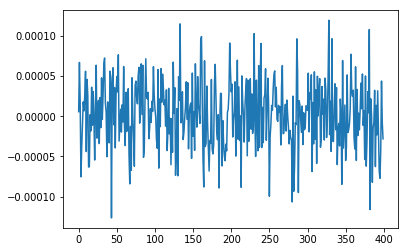

In [22]:
plt.plot(y)

In [23]:
sigma_Dx = (1000e-6)/3.0
sigma_Dy = (50e-6)/3.0
alpha = PAA_part_set[0]*0.5
Dx = []
Dy = []
delta_alpha = []
delta_Dx = []

angular_jitter=[]
long_jitter=[]
rot_long_jitter = []
OPD_PAAM = []

In [24]:
for i in range(0,len(alpha)):
    Dx.append(np.random.normal(loc=0,scale=sigma_Dx))
    Dy.append(np.random.normal(loc=0,scale=sigma_Dy))
    if i==0:
        delta_alpha.append(0)
        delta_Dx.append(0)
    else:
        delta_alpha.append(alpha[i] - alpha[i-1])
        delta_Dx.append(Dx[i]-Dx[i-1])

    angular_jitter.append((2**0.5)*(Dx[i]*alpha[i] +Dy[i])*delta_alpha[i])
    long_jitter.append((2**0.5)*(1+0.5*(alpha[i]**2))*delta_Dx[i])
    rot_long_jitter.append((2**0.5)*delta_alpha[i])
    
    OPD_PAAM.append((Dy[i]-Dx[i]*np.tan(alpha[i]))*(np.sin(alpha[i])/np.sin(np.radians(135)+alpha[i]))*(1-np.cos(np.radians(90) - 2*alpha[i])))



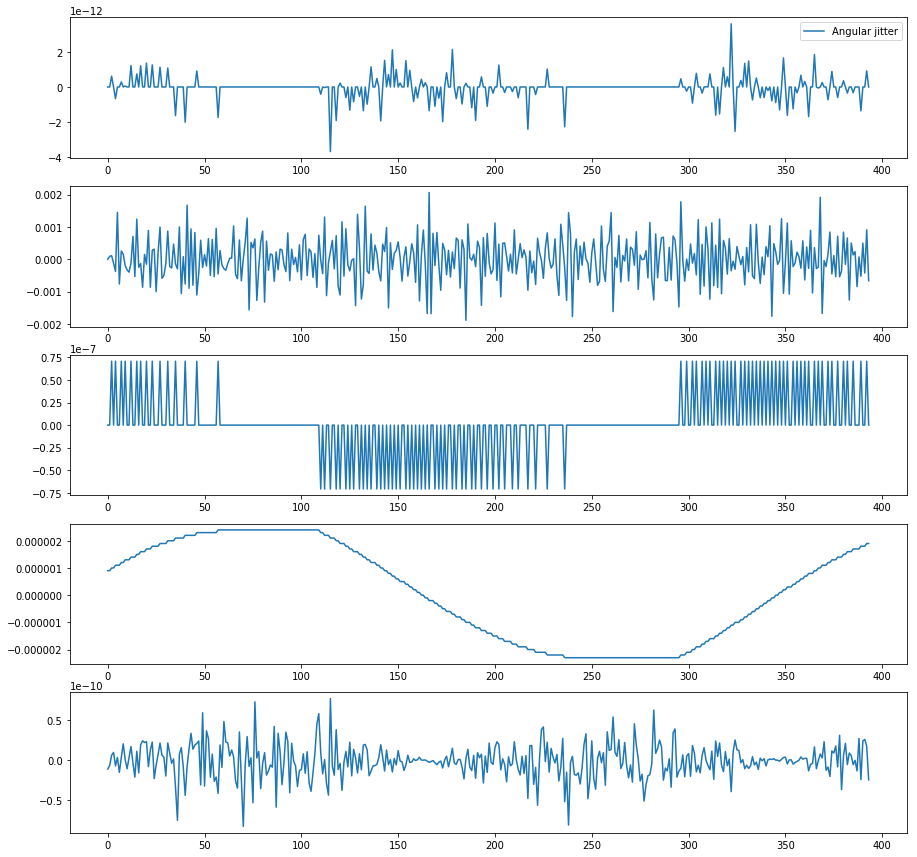

In [25]:
f,ax = plt.subplots(5,1,figsize=(15,15))
ax[0].plot(angular_jitter,label='Angular jitter')
ax[1].plot(long_jitter,label='Longitudinal jitter')
ax[2].plot(rot_long_jitter,label='Rotation longitudinal jitter')
ax[3].plot(PAA_part_set[0],label='PAA')
ax[4].plot(OPD_PAAM,label='OPD')
ax[0].legend(loc='best')

In [26]:
len(OPD_PAAM)

394

In [27]:
len(t)

400

In [28]:
data.t_calc[0][0]

0.0

/home/ester/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


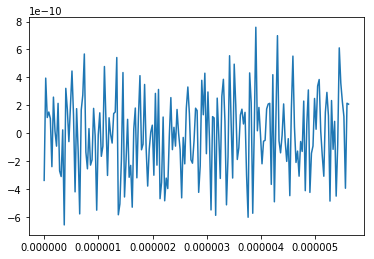

In [29]:
t = data.t_calc[0][data.offset:-data.offset]
N = len(OPD_PAAM)
T = t[1]-t[0]
xf = np.linspace(0,1.0/(2*T),N/2 +1)
OPD_FFT = np.fft.rfft(OPD_PAAM)
plt.plot(xf,OPD_FFT)

In [30]:
freq_lasernoise_PSD = lambda f: 40

In [31]:
N=4096
f0 = 1e-6
f_max = 1e-3
M = N/2 +1
df = (f_max-f0)/M
f_lin = np.linspace(f0,f_max,M)
psd_lin = freq_lasernoise_PSD(f_lin)
ASD=[]
phi = []
Z_neg = []
Z_pos = []
for f in f_lin:
    psd_ph = freq_lasernoise_PSD(f)*(f**2)
    ASD.append((psd_ph*2)**0.5)
    phi.append(random.random()*2*np.pi)
    Z_pos.append(ASD[-1]*np.exp(1j*phi[-1]))
    Z_neg.append(ASD[-1]*np.exp(1j*random.random()*2*np.pi))

Z1 = [0]*(N/2)
Z_tot=[0]
for i in range(0,len(Z_pos)):
    Z_tot.append(Z_pos[i])
for i in range(0,len(Z_neg)):
    Z_tot.append(Z_neg[i])
IFFT = np.fft.ifft(Z_tot)
Dt = 1/(2.0*f_max)
t0 = 0
t_max = (N-1)*Dt
t_IFFT = np.linspace(t0,t_max,len(IFFT))
laser_pn = real(IFFT)

In [32]:
N=4096
f0 = 1e-6
f_max = 1e-3
M = N/2 +1
df = (f_max-f0)/M
f_lin = np.linspace(f0,f_max,M)
psd_lin = freq_lasernoise_PSD(f_lin)
ASD=[]
phi = []
Z_neg = []
Z_pos = []
for f in f_lin:
    psd_ph = freq_lasernoise_PSD(f)
    ASD.append((psd_ph*2)**0.5)
    phi.append(random.random()*2*np.pi)
    Z_pos.append(ASD[-1]*np.exp(1j*phi[-1]))
    Z_neg.append(ASD[-1]*np.exp(1j*random.random()*2*np.pi))

Z1 = [0]*(N/2)
Z_tot=[0]
for i in range(0,len(Z_pos)):
    Z_tot.append(Z_pos[i])
for i in range(0,len(Z_neg)):
    Z_tot.append(Z_neg[i])
IFFT = np.fft.ifft(Z_tot)
Dt = 1/(2.0*f_max)
t0 = 0
t_max = (N-1)*Dt
t_IFFT = np.linspace(t0,t_max,len(IFFT))
laser_fn = real(IFFT)

In [33]:
PAAM_pn_1 = np.array(OPD_PAAM)/np.array(labda)
PAAM_pn_2 = np.array(OPD_PAAM)/np.array(c/((c/labda)+laser_fn[0:len(OPD_PAAM)])) # Corrected for frequency noise laser

/home/ester/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


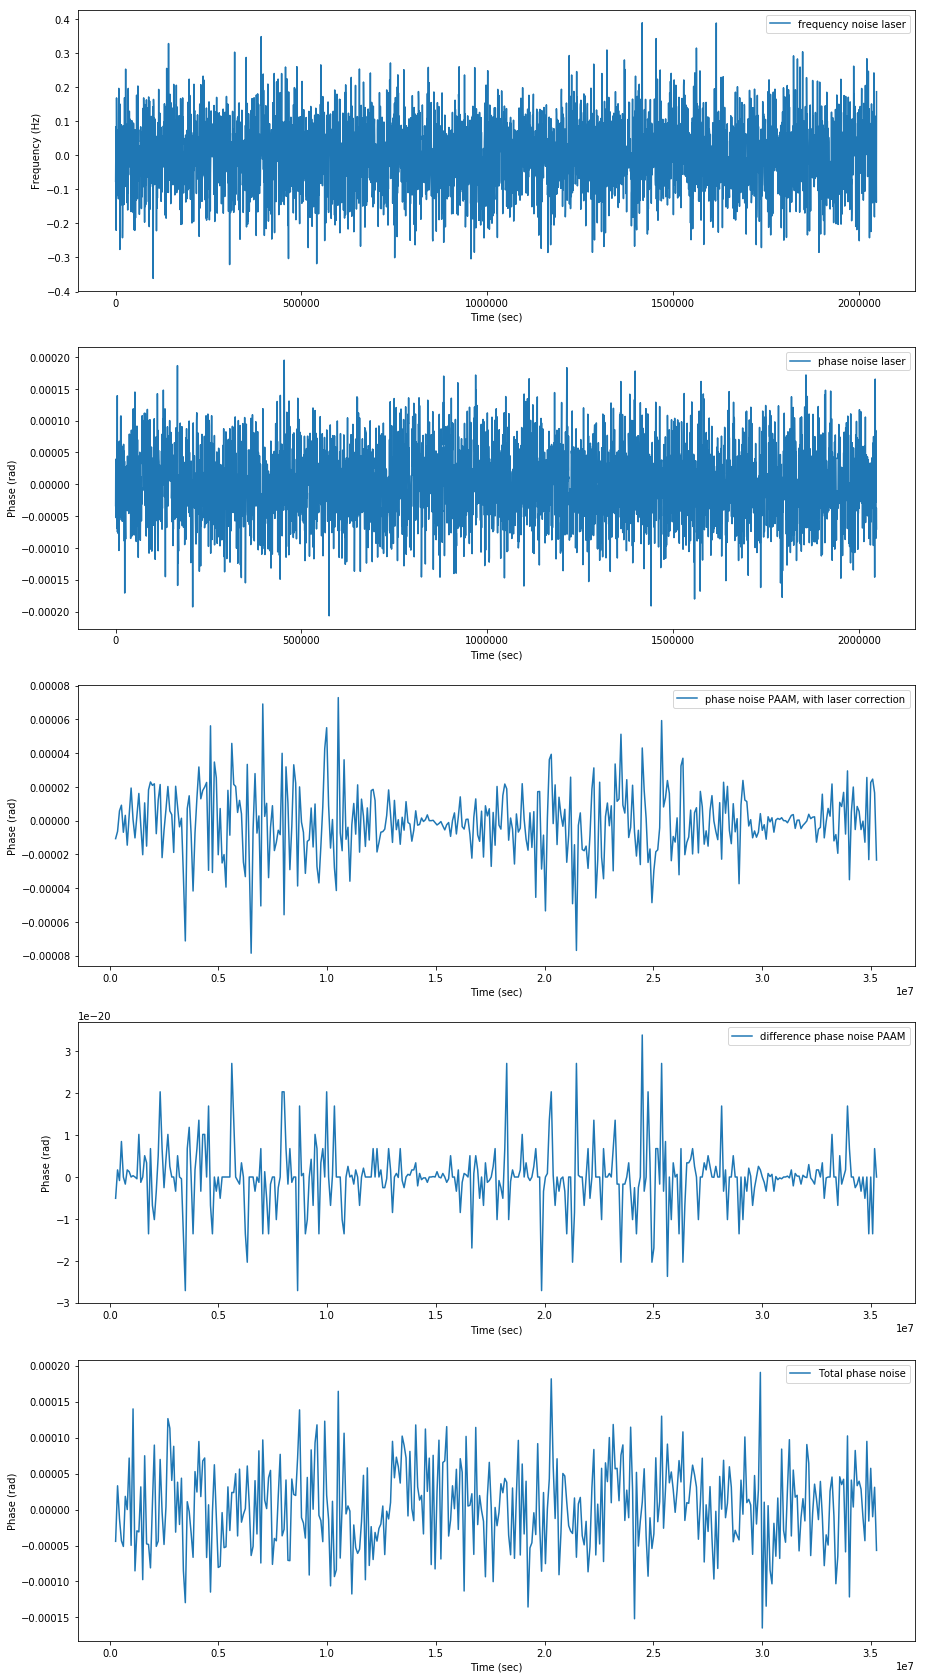

In [34]:
f,ax = plt.subplots(5,1,figsize=(15,30))
ax[0].plot(t_IFFT,laser_fn,label='frequency noise laser')
ax[0].set_ylabel('Frequency (Hz)')
ax[1].plot(t_IFFT,laser_pn,label='phase noise laser')
ax[1].set_ylabel('Phase (rad)')
ax[2].plot(data.t_calc[0][data.offset:-data.offset],PAAM_pn_2,label='phase noise PAAM, with laser correction')
ax[2].set_ylabel('Phase (rad)')
ax[3].plot(data.t_calc[0][data.offset:-data.offset],PAAM_pn_1 - PAAM_pn_2,label='difference phase noise PAAM')
ax[3].set_ylabel('Phase (rad)')
ax[4].plot(data.t_calc[0][data.offset:-data.offset],PAAM_pn_2+laser_pn[:len(PAAM_pn_2)],label='Total phase noise')
ax[4].set_ylabel('Phase (rad)')



for j in ax:
    j.legend(loc='best')
    j.set_xlabel('Time (sec)')
f.show()

In [35]:
def PSD(f_list,SD_list):
    return interp1d(f_list,SD_list)

def PowerLaw(SD_val,f0,exp=1):
    return lambda f: (SD_val)*((f/f0)**exp)

def add_func_help(func_list,f):

    func_ret = func_list[0]

    if len(func_list)>1:
        for i in range(1,len(func_list)):
            func_ret = func_ret(f)+func_list[i](f)

    return func_ret

def add_func(func_list):

    return lambda f: add_func_help(func_list,f)


def Noise(f0,f_max,N,psd,unit):
    M = N/2.0 +1
    df = (f_max-f0)/M

    f_lin = np.linspace(f0,f_max,M)
    psd_lin = psd(f_lin)

    ASD=[]
    phi = []
    Z_neg = []
    Z_pos = []
    for f in f_lin:
        if unit =='phasepercycle':
            ASD.append((((psd(f)**2)*2*np.pi)*2)**0.5)
        else:
            ASD.append((psd(f)*2)**0.5)
        phi.append(random.random()*2*np.pi)
        Z_pos.append(ASD[-1]*np.exp(1j*phi[-1]))
        Z_neg.append(ASD[-1]*np.exp(1j*random.random()*2*np.pi))


    Z1 = [0]*(N/2)
    Z_tot=[0]
    for i in range(0,len(Z_pos)):
        Z_tot.append(Z_pos[i])
    for i in range(0,len(Z_neg)):
        Z_tot.append(Z_neg[i])

    IFFT = np.fft.ifft(Z_tot)
    Dt = 1/(2.0*f_max)
    t0 = 0
    t_max = (N-1)*Dt
    t_IFFT = np.linspace(t0,t_max,len(IFFT))

    return [t_IFFT,IFFT]

def Noise_time(f0,f_max,N,psd,t_stop,unit='freq'):
    t_max = 0
    count=0
    while t_max< t_stop:
        #print(count)
        [t_IFFT,IFFT] = Noise(f0,f_max,N,psd,unit=unit)
        if count!=0:
            t_tot = np.concatenate((t_tot,t_IFFT+t_tot[-1]))
            noise_tot = np.concatenate((noise_tot,IFFT))
        elif count==0:
            t_tot = t_IFFT
            noise_tot = IFFT
        t_max = t_tot[-1]
        print(t_max)
        count=count+1

    t_ret = []
    noise_ret = []
    for i in range(0,len(t_tot)):
        if t_tot[i]<=t_stop:
            t_ret.append(t_tot[i])
            noise_ret.append(noise_tot[i])
    t_ret = np.array(t_ret)
    noise_ret = np.array(noise_ret)

    func_noise = interp1d(t_ret,noise_ret)

    return [t_ret,noise_ret],func_noise


In [40]:
noise_elec = PowerLaw(1e10,1e-8,-1) #Phase noise (cycles/hz**0.5)
noise_opt = noise_elec
noise_opt_elec = lambda f: noise_elec(f)+noise_opt(f)
[t_ret,noise_ret],func_noise = Noise_time(1e-8,1e-2,4096,noise_opt_elec,data.t_plot[0][-data.offset],unit='phasepercycle')

/home/ester/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


204750.0
409500.0
614250.0
819000.0
1023750.0
1228500.0
1433250.0
1638000.0
1842750.0
2047500.0
2252250.0
2457000.0
2661750.0
2866500.0
3071250.0
3276000.0
3480750.0
3685500.0
3890250.0
4095000.0
4299750.0
4504500.0
4709250.0
4914000.0
5118750.0
5323500.0
5528250.0
5733000.0
5937750.0
6142500.0
6347250.0
6552000.0
6756750.0
6961500.0
7166250.0
7371000.0
7575750.0
7780500.0
7985250.0
8190000.0
8394750.0
8599500.0
8804250.0
9009000.0
9213750.0
9418500.0
9623250.0
9828000.0
10032750.0
10237500.0
10442250.0
10647000.0
10851750.0
11056500.0
11261250.0
11466000.0
11670750.0
11875500.0
12080250.0
12285000.0
12489750.0
12694500.0
12899250.0
13104000.0
13308750.0
13513500.0
13718250.0
13923000.0
14127750.0
14332500.0
14537250.0
14742000.0
14946750.0
15151500.0
15356250.0
15561000.0
15765750.0
15970500.0
16175250.0
16380000.0
16584750.0
16789500.0
16994250.0
17199000.0
17403750.0
17608500.0
17813250.0
18018000.0
18222750.0
18427500.0
18632250.0
18837000.0
19041750.0
19246500.0
19451250.0
1965600

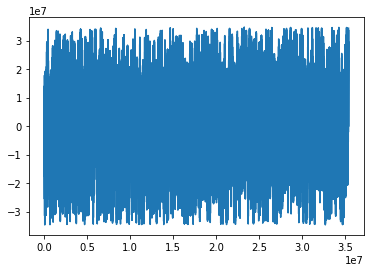

In [44]:
plt.plot(t_ret,real(noise_ret))

In [53]:
# Proofmass noise
pm_noise1 = PowerLaw(5e-11,1e-3,exp=-1)
pm_noise2 = PowerLaw(5e-12,1e-3,exp=0)
pm_psd = lambda f: (pm_noise1(f)+pm_noise2(f))**2 #(m**2/Hz) 

In [54]:
[t_ret,noise_ret],func_noise = Noise_time(1e-8,1e-2,4096,pm_psd,data.t_plot[0][-data.offset])

/home/ester/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


204750.0
409500.0
614250.0
819000.0
1023750.0
1228500.0
1433250.0
1638000.0
1842750.0
2047500.0
2252250.0
2457000.0
2661750.0
2866500.0
3071250.0
3276000.0
3480750.0
3685500.0
3890250.0
4095000.0
4299750.0
4504500.0
4709250.0
4914000.0
5118750.0
5323500.0
5528250.0
5733000.0
5937750.0
6142500.0
6347250.0
6552000.0
6756750.0
6961500.0
7166250.0
7371000.0
7575750.0
7780500.0
7985250.0
8190000.0
8394750.0
8599500.0
8804250.0
9009000.0
9213750.0
9418500.0
9623250.0
9828000.0
10032750.0
10237500.0
10442250.0
10647000.0
10851750.0
11056500.0
11261250.0
11466000.0
11670750.0
11875500.0
12080250.0
12285000.0
12489750.0
12694500.0
12899250.0
13104000.0
13308750.0
13513500.0
13718250.0
13923000.0
14127750.0
14332500.0
14537250.0
14742000.0
14946750.0
15151500.0
15356250.0
15561000.0
15765750.0
15970500.0
16175250.0
16380000.0
16584750.0
16789500.0
16994250.0
17199000.0
17403750.0
17608500.0
17813250.0
18018000.0
18222750.0
18427500.0
18632250.0
18837000.0
19041750.0
19246500.0
19451250.0
1965600

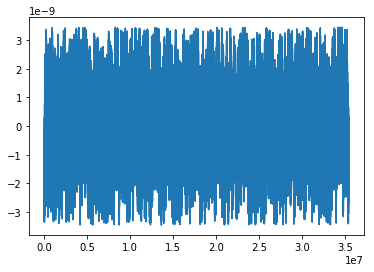

In [55]:
plt.plot(t_ret,noise_ret)

In [62]:
t_dop = t_IFFT
NU_0 = c/labda
C_i = laser_fn/NU_0
C_i_func = interp1d(t_dop,C_i)